# Image based comment generator for Reddit

### Kenneth Chen 
kl682@berkeley 



In [1]:
## Parameters to add 
subreddit = 'pics'
limit = 5

### Image retrieving from the subreddits

In [2]:
#!/usr/bin/env python2
"""Download images from a reddit.com subreddit."""

import os
import re
import io
import sys
import logging
from urllib.request import urlopen
from urllib.error import HTTPError, URLError
from http.client import InvalidURL
from argparse import ArgumentParser
from os.path import (
    exists as pathexists, join as pathjoin, basename as pathbasename,
    splitext as pathsplitext)
from os import mkdir, getcwd
import time

from redditdownload.gfycat import gfycat
from redditdownload.reddit import getitems
from redditdownload.deviantart import process_deviant_url

# for downloading comments
import praw
import pdb
import re
import os
import json

# for converting png to jpg
from PIL import Image


_log = logging.getLogger('redditdownload')


def request(url, *ar, **kwa):
    _retries = kwa.pop('_retries', 4)
    _retry_pause = kwa.pop('_retry_pause', 0)
    res = None
    for _try in range(_retries):
        try:
            res = urlopen(url, *ar, **kwa)
        except Exception as exc:
            if _try == _retries - 1:
                raise
            print("Try %r err %r  (%r)" % (
                _try, exc, url))
        else:
            break
    return res


# '.wrong_type_pages.jsl'
_WRONGDATA_LOGFILE = os.environ.get('WRONGDATA_LOGFILE')


def _log_wrongtype(_logfile=_WRONGDATA_LOGFILE, **kwa):
    if not _logfile:
        return
    import json
    data = json.dumps(kwa) + "\n"
    with open(_logfile, 'a', 1) as f:
        f.write(data)


class WrongFileTypeException(Exception):
    """Exception raised when incorrect content-type discovered"""


class FileExistsException(Exception):
    """Exception raised when file exists in specified directory"""


def extract_imgur_album_urls(album_url):

    response = request(album_url)
    info = response.info()

    # Rudimentary check to ensure the URL actually specifies an HTML file
    if 'content-type' in info and not info['content-type'].startswith('text/html'):
        return []

    filedata = response.read().decode('utf-8')
    # TODO: stop parsing HTML with regexes.
    match = re.compile(r'\"hash\":\"(.[^\"]*)\",\"title\"')
    items = []

    #original
    memfile = io.StringIO(filedata)
    #memfile = io.BytesIO(filedata)

    for line in memfile.readlines():
        results = re.findall(match, line)
        if not results:
            continue

        items += results

    memfile.close()
    # TODO : url may contain gif image.
    urls = ['http://i.imgur.com/%s.jpg' % (imghash) for imghash in items]

    return urls


def download_from_url(url, dest_file):
    # Don't download files multiple times!
    if pathexists(dest_file):
        raise FileExistsException('URL [%s] already downloaded.' % url)

    response = request(url)
    info = response.info()
    actual_url = response.url
    if actual_url == 'http://i.imgur.com/removed.png':
        raise HTTPError(actual_url, 404, "Imgur suggests the image was removed", None, None)

    # Work out file type either from the response or the url.
    if 'content-type' in list(info.keys()):
        filetype = info['content-type']
    elif url.endswith('.jpg') or url.endswith('.jpeg'):
        filetype = 'image/jpeg'
    elif url.endswith('.png'):
        filetype = 'image/png'
    elif url.endswith('.gif'):
        filetype = 'image/gif'
    elif url.endswith('.mp4'):
        filetype = 'video/mp4'
    elif url.endswith('.webm'):
        filetype = 'video/webm'
    else:
        filetype = 'unknown'

    # Only try to download acceptable image types
    if filetype not in ['image/jpeg', 'image/png', 'image/gif', 'video/webm', 'video/mp4']:
        raise WrongFileTypeException('WRONG FILE TYPE: %s has type: %s!' % (url, filetype))

    filedata = response.read()
    filehandle = open(dest_file, 'wb')
    filehandle.write(filedata)
    filehandle.close()

    #converting png to jpg so that images can be trained in CNN
    if filetype == 'image/png':
        im = Image.open(dest_file)
        im_jpg = im.convert('RGB')
        im_jpg.save(dest_file.split('.')[0] + '.jpg')


def process_imgur_url(url):

    if 'imgur.com/a/' in url or 'imgur.com/gallery/' in url:
        return extract_imgur_album_urls(url)

    # use beautifulsoup4 to find real link
    # find vid url only
    try:
        from bs4 import BeautifulSoup
        html = urlopen(url).read()
        soup = BeautifulSoup(html, 'lxml')
        vid = soup.find('div', {'class': 'video-container'})
        vid_type = 'video/webm'  # or 'video/mp4'
        vid_url = vid.find('source', {'type': vid_type}).get('src')
        if vid_url.startswith('//'):
            vid_url = 'http:' + vid_url
        return vid_url

    except Exception:
        # do nothing for awhile
        pass
    # Change .png to .jpg for imgur urls.
    if url.endswith('.png'):
        url = url.replace('.png', '.jpg')
    else:
        # Extract the file extension
        ext = pathsplitext(pathbasename(url))[1]
        if ext == '.gifv':
            url = url.replace('.gifv', '.gif')
        if not ext:
            # Append a default
            url += '.jpg'
    return [url]


def extract_urls(url):

    urls = []

    if 'imgur.com' in url:
        urls = process_imgur_url(url)
    elif 'deviantart.com' in url:
        urls = process_deviant_url(url)
    elif 'gfycat.com' in url:
        # choose the smallest file on gfycat
        gfycat_json = gfycat().more(url.split("gfycat.com/")[-1]).json()
        if gfycat_json["mp4Size"] < gfycat_json["webmSize"]:
            urls = [gfycat_json["mp4Url"]]
        else:
            urls = [gfycat_json["webmUrl"]]
    else:
        urls = [url]

    return urls

In [3]:
def download_reddit(sreddit, path, limit=5):
    
    if not pathexists(path):
        mkdir(path)

    reddit = praw.Reddit('bot1')
    
    start_time = None

    TOTAL = DOWNLOADED = ERRORS = SKIPPED = FAILED = 0
    
    count = 0
    current_img_list = []
    
    for submission in reddit.subreddit(sreddit).hot(limit=limit):
        count += 1
 
        end_time = time.clock()

        if start_time is not None:
            elapsed_time = end_time - start_time

            if elapsed_time <= 4:  # throttling
                time.sleep(4 - elapsed_time)

        start_time = time.clock()

        FILECOUNT = 0
        try:
            URLS = extract_urls(submission.url)     
            filename = submission.id + '.jpg'
            current_img_list.append(filename)
        except Exception:
            _log.exception("Failed to extract urls for %r", URLS)
            continue

        for URL in URLS:
            try:
                # Find gfycat if requested
                #original
                if URL.endswith('gif'):
                    check = gfycat().check(URL)
                    if check.get("urlKnown"):
                        URL = check.get('webmUrl')

                FILEEXT = pathsplitext(URL)[1]
                # Trim any http query off end of file extension.
                FILEEXT = re.sub(r'\?.*$', '', FILEEXT)
                if not FILEEXT:
                    # A more usable option that empty.
                    # The extension can be fixed after downloading, but then the 'already downloaded' check will be harder.
                    FILEEXT = '.jpg'

                # Only append numbers if more than one file
                FILENUM = ('_%d' % FILECOUNT if len(URLS) > 1 else '')

                FILENAME = '%s%s%s' % (submission.id, FILENUM, FILEEXT)

                FILEPATH = pathjoin(path, FILENAME)

                # Improve debuggability list URL before download too.
                # url may be wrong so skip that
                if URL.encode('utf-8') == 'http://':
                    raise URLError('Url is empty')
                else:
                    text_templ = '    Attempting to download URL[{}] as [{}].'
                    #print(text_templ.format(URL.encode('utf-8'), FILENAME.encode('utf-8')))

                # Download the image
                try:
                    download_from_url(URL, FILEPATH)
                    #download_comments(ITEM[id])
                    # Image downloaded successfully
                    print(' -->  submission{} : Successfully downloaded URL {} as {}'.format(count,URL, FILENAME))
                    #print("-"*50)
                    DOWNLOADED += 1
                    FILECOUNT += 1

                except Exception as exc:
                    print('    %s' % (exc,))
                    ERRORS += 1

            except WrongFileTypeException as ERROR:
                print('    %s' % (ERROR,))
                _log_wrongtype(url=URL, target_dir=ARGS.dir,
                               filecount=FILECOUNT, _downloaded=DOWNLOADED,
                               filename=FILENAME)
                SKIPPED += 1
            except FileExistsException as ERROR:
                print('    %s' % (ERROR,))
                ERRORS += 1
            except HTTPError as ERROR:
                print('    HTTP ERROR: Code %s for %s.' % (ERROR.code, URL))
                FAILED += 1
            except URLError as ERROR:
                print('    URL ERROR: %s!' % (URL,))
                FAILED += 1
            except InvalidURL as ERROR:
                print('    Invalid URL: %s!' % (URL,))
                FAILED += 1
            except Exception as exc:
                _log.exception("Problem with %r: %r", URL, exc)
                FAILED += 1
            
    with open("current_img_list.txt", "w") as f:
        for img in current_img_list:
            f.write(str(img) + '\n')
            
    print("Current image list : ", current_img_list)
    print('Downloaded {} files'.format(DOWNLOADED),
          '(Processed {}, Skipped {}, Exists {})'.format(TOTAL, SKIPPED, ERRORS))

In [4]:
data_dir = 'data/reddit/'
path_to_save = data_dir + subreddit

download_reddit(subreddit, path_to_save, limit)

 -->  submission1 : Successfully downloaded URL https://i.redd.it/zxwwjgnp4jp31.jpg as dauon5.jpg
 -->  submission2 : Successfully downloaded URL https://imgur.com/hqdhi7W.jpg as darkgw.jpg
 -->  submission3 : Successfully downloaded URL https://i.redd.it/448zw1bq3gp31.jpg as dapj94.jpg
 -->  submission4 : Successfully downloaded URL https://i.imgur.com/qg4kOVH.jpg as davdpp.jpg
 -->  submission5 : Successfully downloaded URL https://i.imgur.com/qDppsbr.jpg as dasj6n.jpg
Current image list :  ['dauon5.jpg', 'darkgw.jpg', 'dapj94.jpg', 'davdpp.jpg', 'dasj6n.jpg']
Downloaded 5 files (Processed 0, Skipped 0, Exists 0)


## Imports

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sys
import os
from PIL import Image
from cache import cache

# We need to import several things from Keras.
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding, Dropout
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

### Loading Reddit Dataset

In [6]:
def load_image(path, size=None):
    """
    Load the image from the given file-path and resize it
    to the given size if not None.
    """
    # Load the image using PIL.
    img = Image.open(path)

    # Resize image if desired.
    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)
        
    # Convert image to numpy array and scale the pixel between 0 and 1.
    img = np.array(img)
    img = img / 255.0

    # Convert 2-dim gray-scale array to 3-dim RGB array.
    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

    return img

def show_image(idx, train):

    if train:
        # Use an image from the training-set.
        dir = "data/reddit/dataset/"
        filename = filenames_reddit[idx]
        captions = captions_reddit[idx]
    else:
        # Use an image from the validation-set.
        dir = coco.val_dir
        filename = filenames_flickr30k_val[idx]
        captions = captions_flickr30k_val[idx]

    # Path for the image-file.
    path = os.path.join(dir, filename)

    # Print the captions for this image.
    for caption in captions:
        print(caption)
    
    # Load the image and plot it.
    img = load_image(path)
    plt.imshow(img)
    plt.show()

### Example Image

Show an example image and captions from the training-set.

In [7]:
# This is removing some images that do not have 3 channels RGB or 
# multiple images in each submission that makes it harder to retrieve the image features.
# So listing them as blacklist and remove them in the filenames_reddit 

import re
import reddit_img

token = 'filenames.txt'
filenames = open(token, 'r').read().strip().split('\n')
filenames_reddit = tuple(filenames) 

with open ('captions.json') as f:
    comments = json.loads(f.read())
captions_reddit = tuple(comments)

## Pre-Trained Image Model (VGG16)


In [8]:
# https://keras.io/applications/#vgg16
# keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', \
# input_tensor=None, input_shape=None, pooling=None, classes=1000)

model_vgg16 = VGG16(include_top=True, weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


### Model (1) : A modified model transferred from VGG16

We modify the VGG16 model by removing the final classification layer or predictions layer. 

In [9]:
# getting the intermediate layer from VGG16
transfer_layer = model_vgg16.get_layer('fc2')

# A model expects the input size as follows
img_size = K.int_shape(model_vgg16.input)[1:3]
print("Input to a new model    : ", img_size)

# A new model will output a vector of `4096` in size
transfer_values_size = K.int_shape(transfer_layer.output)[1]
print("Output from a new model : ", transfer_values_size)

# Building the model 
model_transferred = Model(inputs=model_vgg16.input, outputs=transfer_layer.output)

Input to a new model    :  (224, 224)
Output from a new model :  4096


### Process All Images

This will process all COCO train images `118,287` in VGG16 architecture and save the output `4096` from each image and store them in pickle format so that we can retrieve the transfer values in next run. We will not train the entire VGG16 weights, which will take a long time to train. Instead, we will use the weights trained on ImageNet and save the output `4096` values as our COCO images transfer values from VGG16 model. 

In [10]:
def print_progress(count, max_count):

    # Status-message. Note the \r which means the line should overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(count/max_count)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

In [11]:
# Any images using the VGG16 model, 
# using `predict()` function to get the image vector out of VGG16 CNN

def process_images(data_dir, filenames, batch_size=32):
    
    # Number of images to process.
    total_images = len(filenames)

    # Pre-allocate input-batch-array for images.
    shape = (batch_size,) + img_size + (3,)                  # (32,) + (224, 224) + (3,) = (32, 224, 224, 3)
    image_batch = np.zeros(shape=shape, dtype=np.float16)    # (32, 224, 224, 3) input format for VGG16

    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (total_images, transfer_values_size)             # (187, 4096)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    # Initialize index into the filenames.
    start_index = 0

    # Process batches of image-files.
    while start_index < total_images:
        print_progress(count=start_index, max_count=total_images)

        # End-index for this batch.
        end_index = start_index + batch_size                 # 0 + 32 = 32 for 1st batch

        # Ensure end-index is within bounds.
        if end_index > total_images:
            end_index = total_images

        # The last batch may have a different batch-size.
        current_batch_size = end_index - start_index

        # Load all the images in the batch.
        for i, filename in enumerate(filenames[start_index:end_index]):
            # Path for the image-file.
            path = os.path.join(data_dir, filename)

            # Load and resize the image. This returns the image as a numpy-array.
            img = load_image(path, size=img_size)

            # Save the image for later use.
            image_batch[i] = img

        # Use the pre-trained image-model to process the image.
        # Note that the last batch may have a different size,
        # so we only use the relevant images.
        transfer_values_batch = model_transferred.predict(image_batch[0:current_batch_size])

        # Save the transfer-values in the pre-allocated array.
        transfer_values[start_index:end_index] = transfer_values_batch[0:current_batch_size]

        # Increase the index for the next loop-iteration.
        start_index = end_index

    # Print newline.
    print()

    return transfer_values

This is the function for processing the given files using the VGG16-model and returning their transfer-values.

Helper-function for processing all images in the training-set. This saves the transfer-values in a cache-file for fast reloading.

In [12]:
def process_images_train():
    print("Processing {0} images in training-set ...".format(len(filenames_reddit)))

    # Path for the cache-file.
    cache_path = os.path.join(reddit_img.data_dir, "transfer_values_reddit.pkl")
    
    # def process_images has 3 arguments: data_dir, filenames, batch_size
    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=reddit_img.train_dir,
                            filenames=filenames_reddit)

    return transfer_values

Process all images in the training-set and save the transfer-values to a cache-file. This took about 30 minutes to process on a GTX 1070 GPU.

In [13]:
%%time
transfer_values_reddit = process_images_train()
print("dtype:", transfer_values_reddit.dtype)
print("shape:", transfer_values_reddit.shape)

Processing 506 images in training-set ...
- Data loaded from cache-file: data/reddit/transfer_values_reddit.pkl
dtype: float16
shape: (506, 4096)
CPU times: user 2.66 ms, sys: 4.44 ms, total: 7.1 ms
Wall time: 9.57 ms


## Tokenizer

We will need to tokenize the caption because neural network cannot work on literal string text. In order to create a corpus for all the captions, we first tokenize each word in each caption and create a dictionary. Since we'd be using the skip-gram model, which predict next words (context words) based on the current word (target), opposite of CBOW (Continous Bag of Words), we need to pad the start and end characters in each caption. 

There are two models in text prediction. 

- CBOW (Continuous Bag of Words) 
- Skip-gram 


In [14]:
mark_start = 'ssss '
mark_end = ' eeee'

def mark_captions(captions_listlist):
    captions_marked = [[mark_start + caption + mark_end
                        for caption in captions_list]
                        for captions_list in captions_listlist]
    
    return captions_marked

captions_train_marked_reddit = mark_captions(captions_reddit)
captions_train_marked_reddit[3]

['ssss Merely exchanging long protein strings. eeee',
 'ssss Why does the cat look photoshopped eeee',
 'ssss Worst. Photoshop. Ever. eeee',
 'ssss Saw this exact picture about 5 years ago. Without the cat. eeee']

In [15]:
# Since the tokenizer cannot take list of list, we flatten the captions list into a single list.

def flatten(captions_listlist):
    captions_list = [caption
                     for captions_list in captions_listlist
                     for caption in captions_list]
    
    return captions_list

captions_train_flat_reddit = flatten(captions_train_marked_reddit)
captions_train_flat_reddit[:6]

['ssss yes. this is a perfectly natural picture taken on a sunny day. eeee',
 'ssss Reverse Ireland? eeee',
 'ssss Ah yes, here we see a farmer who is going to drive into the Pompeii explosion. eeee',
 'ssss This looks like it’s pulled out of Arrested Development. eeee',
 'ssss "I don\'t know what I expected" eeee',
 'ssss BATEMAN: "I\'m so very grateful to receive this award" Narrator: "He wasn\'t." eeee']

### Tokenization

We need a few more functions than provided by Keras' Tokenizer-class so we wrap it.

In [16]:
class TokenizerWrap(Tokenizer):
    """Wrap the Tokenizer-class from Keras with more functionality."""
    
    def __init__(self, texts, num_words=None):
        """
        :param texts: List of strings with the data-set.
        :param num_words: Max number of words to use.
        """

        Tokenizer.__init__(self, num_words=num_words)

        # Create the vocabulary from the texts.
        self.fit_on_texts(texts)

        # Create inverse lookup from integer-tokens to words.
        self.index_to_word = dict(zip(self.word_index.values(), self.word_index.keys()))

    def token_to_word(self, token):

        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):

        # Create a list of the individual words.
        words = [self.index_to_word[token] for token in tokens if token != 0]
        
        # Concatenate the words to a single string
        text = " ".join(words)

        return text
    
    def captions_to_tokens(self, captions_listlist):
        
        # Note that text_to_sequences() takes a list of texts.
        tokens = [self.texts_to_sequences(captions_list) for captions_list in captions_listlist]
        
        return tokens

Now create a tokenizer using all the captions in the training-data. Note that we use the flattened list of captions to create the tokenizer because it cannot take a list-of-lists.

In [17]:
%%time
num_words = 10000
tokenizer = TokenizerWrap(texts=captions_train_flat_reddit,
                          num_words=num_words)

CPU times: user 63.5 ms, sys: 3.85 ms, total: 67.4 ms
Wall time: 67.1 ms


Get the integer-token for the start-marker (the word "ssss"). We will need this when we generate captions.

In [18]:
token_start = tokenizer.word_index[mark_start.strip()]
print("token_start: ", token_start)
token_end = tokenizer.word_index[mark_end.strip()]
print("token_end  : ", token_end)

token_start:  1
token_end  :  2


Convert all the captions from the training-set to sequences of integer-tokens. We get a list-of-list as a result.

In [19]:
%%time
tokens_train_reddit = tokenizer.captions_to_tokens(captions_train_marked_reddit)

CPU times: user 51.9 ms, sys: 2.07 ms, total: 54 ms
Wall time: 57.9 ms


## Data Batch Generator


In [20]:
num_images_train = len(filenames_reddit)

def get_random_caption_tokens(idx):
    
    result = []

    for i in idx:
        # Get a random index for a token-sequence.
        j = np.random.choice(len(tokens_train_reddit[i]))
        tokens = tokens_train_reddit[i][j]
        result.append(tokens)

    return result


def batch_generator(batch_size):

    while True:
        # Get a list of random indices for images in the training-set.
        idx = np.random.randint(num_images_train, size=batch_size)
        
        # Get the pre-computed transfer-values for those images and their caption randomly (only 1 caption out of 5)
        transfer_values = transfer_values_reddit[idx]
        tokens = get_random_caption_tokens(idx)

        # Count the number of tokens in selected caption
        num_tokens = [len(t) for t in tokens]
        max_tokens = np.max(num_tokens)             # maximum length of the tokenized_caption within a given batch
        
        # Pad all the other token-sequences with zeros
        tokens_padded = pad_sequences(tokens,
                                      maxlen=max_tokens,
                                      padding='post',
                                      truncating='post')
        
        decoder_input_data = tokens_padded[:, 0:-1]      # removing the last token because it can't predict the next word at the end
        decoder_output_data = tokens_padded[:, 1:]       # removing the first token because it is 'ssss ', not predicted from the previous word

        # Dict for the input data
        x_data = \
        {
            'decoder_input': decoder_input_data,
            'transfer_values_input': transfer_values
        }

        # Dict for the output-data.
        y_data = \
        {
            'decoder_output': decoder_output_data
        }
        
        yield (x_data, y_data)

### Generating the input, output data for RNN

In [21]:
batch_size = 512         # Set high to maximal usage at GPU. 

generator = batch_generator(batch_size=batch_size)

# generating one batch worth of input and output to check
batch = next(generator)
batch_x = batch[0]       # input will have 512 images vectors
batch_y = batch[1]       # output will have 512 tokenized captions

print("batch_x has {} images".format(len(batch_x['transfer_values_input'])))
print("sample of first image in the batch")
batch_x['transfer_values_input'][0]

batch_x has 512 images
sample of first image in the batch


array([-0.    , -0.    ,  1.1455, ..., -0.    , -0.    ,  0.3362],
      dtype=float16)

Example of the token-sequence for the first image in the batch. This is the input to the decoder-part of the neural network.

### Model (2) : Create the Recurrent Neural Network (RNN) 



In [22]:
state_size = 512
embedding_size = 128
dropout_rate = 0.8
num_words = 10000

# transfer_values_size = 4096
# transfer value from VGG16 to the RNN
transfer_values_input = Input(shape=(transfer_values_size,), name='transfer_values_input')

decoder_transfer_map = Dense(state_size, activation='tanh', name='decoder_transfer_map')

# This is the input for token-sequences to the decoder.
decoder_input = Input(shape=(None, ), name='decoder_input')

# This is the embedding-layer which converts sequences of integer-tokens to sequences of vectors.
decoder_embedding = Embedding(input_dim=num_words,
                              output_dim=embedding_size,
                              name='decoder_embedding')

# 3 GRU layers 
decoder_gru1 = GRU(state_size, name='decoder_gru1',
                   return_sequences=True)
decoder_gru2 = GRU(state_size, name='decoder_gru2',
                   return_sequences=True)
decoder_gru3 = GRU(state_size, name='decoder_gru3',
                   return_sequences=True)
#decoder_gru4 = GRU(state_size, name='decoder_gru4',
#                   return_sequences=True)
#decoder_gru5 = GRU(state_size, name='decoder_gru5',
#                   return_sequences=True)

# final connected layer 
decoder_dense = Dense(num_words, activation='linear', name='decoder_output')

# dropout layer 
dropout = Dropout(rate=dropout_rate, name='dropout_layer')

## Build the Final Model (VGG16 + RNN) 

The decoder (RNN) is built using the functional API of Keras, which allows more flexibility in connecting the layers e.g. to have multiple inputs. This is useful e.g. if you want to connect the image-model directly with the decoder instead of using pre-calculated transfer-values. This function connects all the layers of the decoder to some input of transfer-values.

In [23]:
dropout_rate = 0.8

def connect_decoder(transfer_values):

    # transferred value from VGG16, will be used in GRU initial_state
    initial_state = decoder_transfer_map(transfer_values)

    # Start the decoder-network with its input-layer and embedding layer
    net = decoder_input
    net = decoder_embedding(net)
    
    # Connect all the GRU layers.
    net = decoder_gru1(net, initial_state=initial_state)
    net = decoder_gru2(net, initial_state=initial_state)
    #net = decoder_gru3(net, initial_state=initial_state)

    #net = dropout(net)
    
    decoder_output = decoder_dense(net)
    
    return decoder_output

Connect and create the model used for training. This takes as input transfer-values and sequences of integer-tokens and outputs sequences of one-hot encoded arrays that can be converted into integer-tokens.

In [24]:
decoder_output = connect_decoder(transfer_values=transfer_values_input)

decoder_model = Model(inputs=[transfer_values_input, decoder_input],
                      outputs=[decoder_output])

### Compile the Training Model


There seems to be another bug in Keras so it cannot automatically deduce the correct shape of the decoder's output data. We therefore need to manually create a placeholder variable for the decoder's output. The shape is set to `(None, None)` which means the batch can have an arbitrary number of sequences, which can have an arbitrary number of integer-tokens.

In [25]:
def sparse_cross_entropy(y_true, y_pred):

    # Calculate the loss. This outputs a 2-rank tensor of shape [batch_size, sequence_length]
    
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)

    # reduce the batch loss to a single scalar loss by taking mean
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

In [26]:
decoder_target = tf.placeholder(dtype='int32', shape=(None, None))

decoder_model.compile(optimizer=RMSprop(lr=1e-3),
                      loss=sparse_cross_entropy,
                      target_tensors=[decoder_target])

### Callback Functions

During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras.

This is the callback for writing checkpoints during training.

In [27]:
# Saving checkpoints for weights
path_checkpoint = 'checkpoints_reddit/checkpoint_w210_reddit.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      verbose=1,
                                      save_weights_only=True)

# Saving logs
callback_tensorboard = TensorBoard(log_dir='./logs_w210/',
                                   histogram_freq=0,
                                   write_graph=False)

# Calling back if there's any previously saved checkpoints
callbacks = [callback_checkpoint, callback_tensorboard]


### Load Checkpoint

You can reload the last saved checkpoint so you don't have to train the model every time you want to use it.

In [28]:
try:
    decoder_model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

## Generate Captions 

This function loads an image and generates a caption using the model we have trained. The model will predict the next word based on the current word. Once we receive the predicted word, we will use the predicted word as our base word and the model will predict the next word. This prediction will continue until the model reaches either (1) the end of the word indicated by `'eeee'` or (2) a user-defined length of the captions. 

In [29]:
def generate_comment(image_path, max_tokens=30):

    # Load and resize the image.
    image = load_image(image_path, size=img_size)
    image_batch = np.expand_dims(image, axis=0)

    # Process the image 
    transfer_values = model_transferred.predict(image_batch)

    # Pre-allocate the 2-dim array used as input to the decoder.
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start

    # Initialize an empty output-text and token count to zero. 
    count_tokens = 0
    output_text = ''

    while token_int != token_end and count_tokens < max_tokens:

        decoder_input_data[0, count_tokens] = token_int          # assign the first word 'ssss ' in the preallocated position

        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }
        
        # Input this data to the decoder and get the predicted output.
        decoder_output = decoder_model.predict(x_data)

        # convert to onehot (actually not one hot exactly), take the index of the largest value by np.argmax, then convert to text by tokenizer
        token_onehot = decoder_output[0, count_tokens, :]
        token_int = np.argmax(token_onehot)                       # update from token 2 ('ssss ') to a new token
        sampled_word = tokenizer.token_to_word(token_int)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens += 1

    # Plot the image.
    plt.imshow(image)
    plt.show()
    
    # strip the end word ' eeee' from the caption
    caption = ' '.join(output_text.split()[:-1])
    # Print the predicted caption.
    print("comment generated:")
    print(caption)
    print()

## Examples on Reddit train, validation and test images

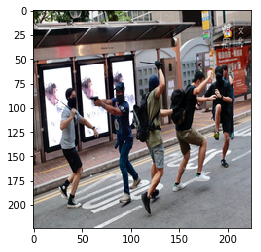

comment generated:
this should be its own sub r hiddenkitties



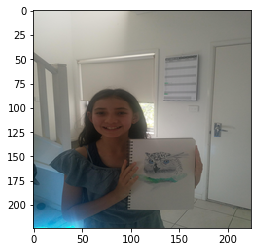

comment generated:
the most dangerous game



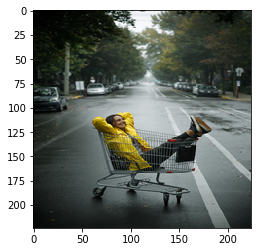

comment generated:
don't be so butthurt



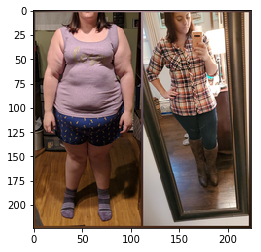

comment generated:
i like what they've done with the place



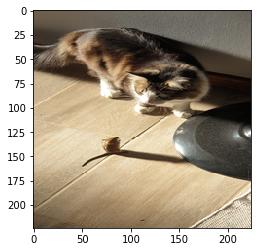

comment generated:
looks like a badass tattoo



In [30]:
data_dir = 'data/reddit/' + subreddit + '/'

current_img_list = open('current_img_list.txt', 'r').read().strip().split('\n')

for filename in current_img_list:
    path = os.path.join(data_dir, filename)
    generate_comment(image_path=path)